In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg as la
from scipy import fft 
from scipy import linalg as la
%matplotlib notebook

In [2]:
# what are we doing? we are trying to get the heart rate (HR) and resipiratory rate (RR)
# how are we going to do this?
# using two techniques, SCG and BCG, that need
# info about the mechanical properties of the human body such as acceleration, angular velocity

# first things first, we load the center_sternum dataset and add a time column as index

df=pd.read_csv("center_sternum.txt",sep=None,engine='python')
df['time_s'] = np.arange(0,df.shape[0])/200 # let's construct the time axis, with each sampling separated by a 200th of a second (because sampling rate is 200 Hz)
df=df.set_index('time_s')
df

Log Mode  Log Freq   Timestamp     AccX     AccY    AccZ      GyroX  \
time_s                                                                        
0.000          5       200  1576222772  947.086  435.662  70.638  -6.824428   
0.005          5       200  1576222772  969.168  387.777  88.877   6.183206   
0.010          5       200  1576222772  989.603  380.335  78.751  11.709920   
0.015          5       200  1576222772  954.894  418.033  88.328  17.877860   
0.020          5       200  1576222772  972.096  427.732  99.857  25.221370   
...          ...       ...         ...      ...      ...     ...        ...   
82.505         5       200  1576222847  958.493  291.092 -54.290   1.664122   
82.510         5       200  1576222847  954.650  288.042 -49.654   1.480916   
82.515         5       200  1576222847  967.338  290.482 -63.867   1.114504   
82.520         5       200  1576222847  965.630  300.852 -56.242   0.702290   
82.525         5       200  1576222847  959.957  298.473 -55.998   0.290076   

            GyroY     GyroZ  MagnX  MagnY  MagnZ        qw        qi  \
time_s                                                                 
0.000  -14.244280  1.404580   -454   -490   -178  0.792622  0.254952   
0.005  -12.290080 -7.969466   -454   -490   -177  0.736461  0.275124   
0.010   -4.961832 -7.450382   -454   -490   -177  0.729465  0.275246   
0.015    2.519084 -5.984733   -454   -492   -176  0.723413  0.277200   
0.020    5.404580  4.015267   -454   -492   -176  0.721948  0.280007   
...           ...       ...    ...    ...    ...       ...       ...   
82.505   2.305344 -0.671756   -494   -449   -126  0.650810  0.379162   
82.510   2.488550 -0.702290   -494   -450   -125  0.650239  0.379803   
82.515   3.374046 -0.900763   -494   -450   -125  0.649365  0.380627   
82.520   3.664122 -1.587786   -495   -448   -124  0.648973  0.381329   
82.525   4.061069 -1.343511   -495   -448   -124  0.648462  0.382336   

              qj        qk  
time_s                      
0.000  -0.553850 -0.000031  
0.005  -0.617969  0.006806  
0.010  -0.626118  0.009827  
0.015  -0.632221  0.011383  
0.020  -0.632679  0.010193  
...          ...       ...  
82.505 -0.636402  0.166356  
82.510 -0.636708  0.165960  
82.515 -0.637227  0.165502  
82.520 -0.637348  0.164953  
82.525 -0.637471  0.164159  

[16506 rows x 16 columns]

In [3]:
#drop some columns 

new_df=df.drop(columns=['Log Mode','Log Freq','Timestamp','MagnX','MagnY','MagnZ','qw','qi','qj','qk'])
new_df

AccX     AccY    AccZ      GyroX      GyroY     GyroZ
time_s                                                          
0.000   947.086  435.662  70.638  -6.824428 -14.244280  1.404580
0.005   969.168  387.777  88.877   6.183206 -12.290080 -7.969466
0.010   989.603  380.335  78.751  11.709920  -4.961832 -7.450382
0.015   954.894  418.033  88.328  17.877860   2.519084 -5.984733
0.020   972.096  427.732  99.857  25.221370   5.404580  4.015267
...         ...      ...     ...        ...        ...       ...
82.505  958.493  291.092 -54.290   1.664122   2.305344 -0.671756
82.510  954.650  288.042 -49.654   1.480916   2.488550 -0.702290
82.515  967.338  290.482 -63.867   1.114504   3.374046 -0.900763
82.520  965.630  300.852 -56.242   0.702290   3.664122 -1.587786
82.525  959.957  298.473 -55.998   0.290076   4.061069 -1.343511

[16506 rows x 6 columns]

<IPython.core.display.Javascript object>


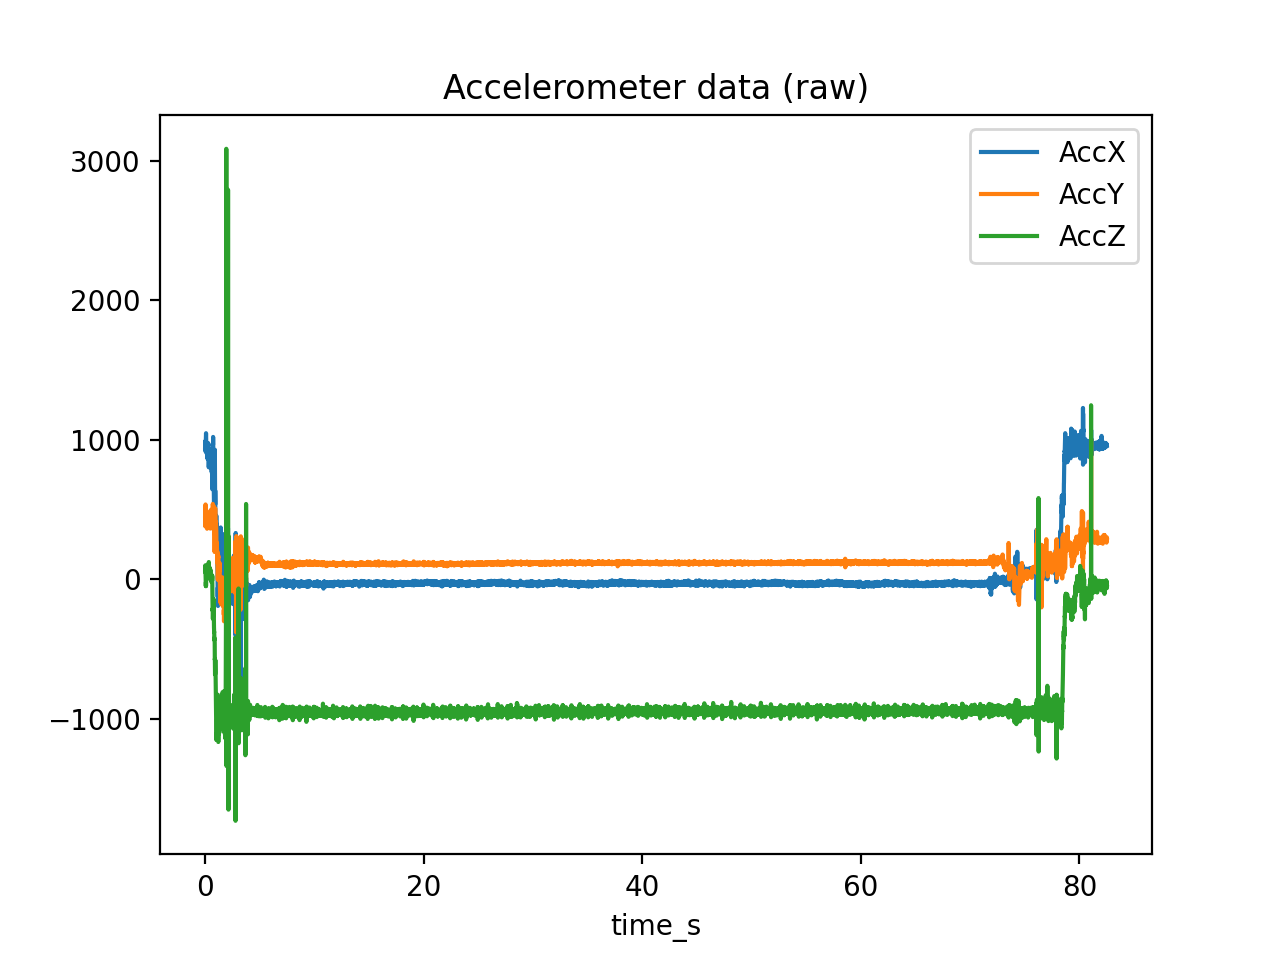

<IPython.core.display.Javascript object>


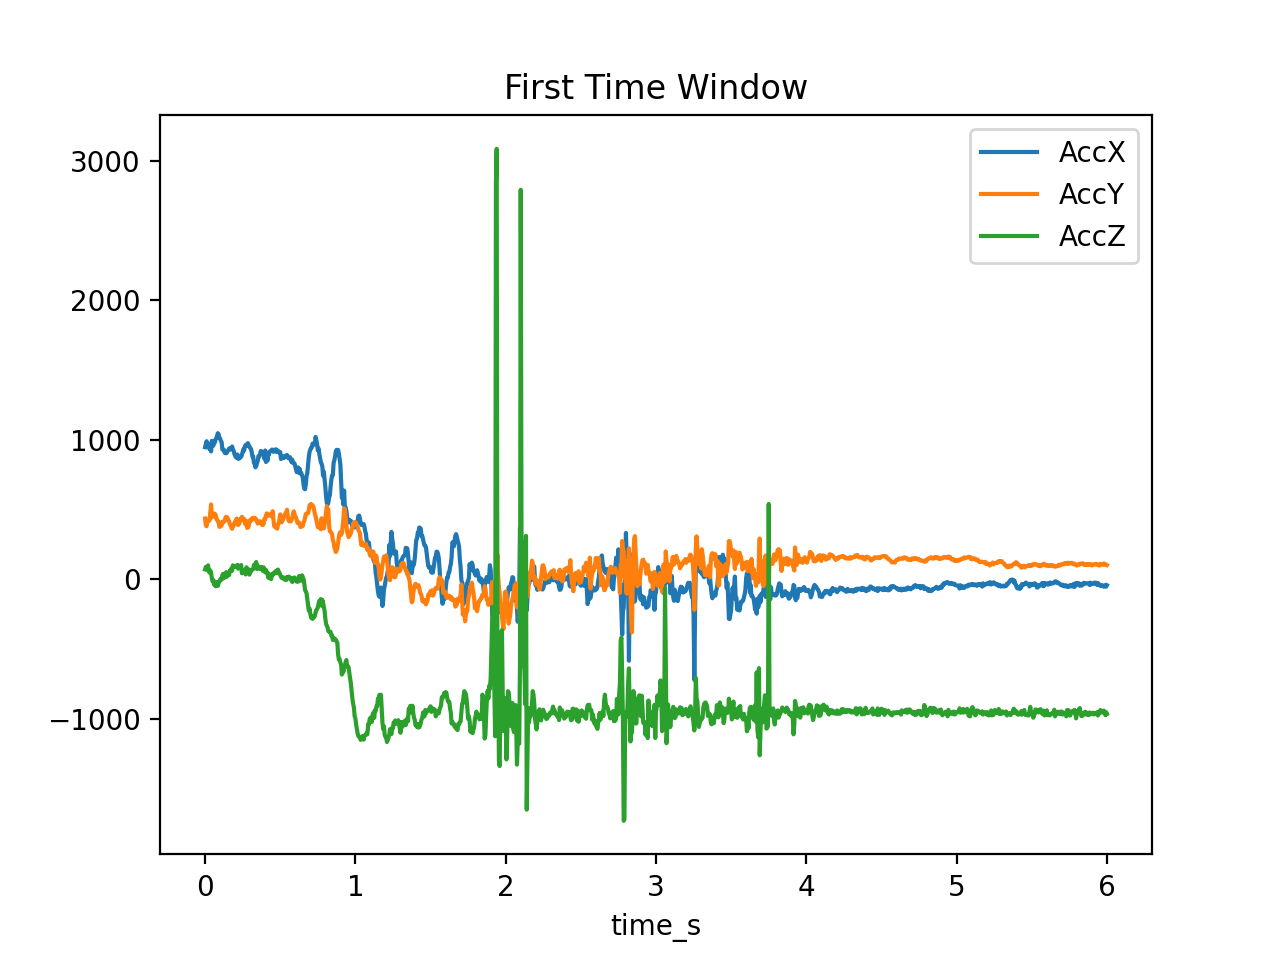

<IPython.core.display.Javascript object>


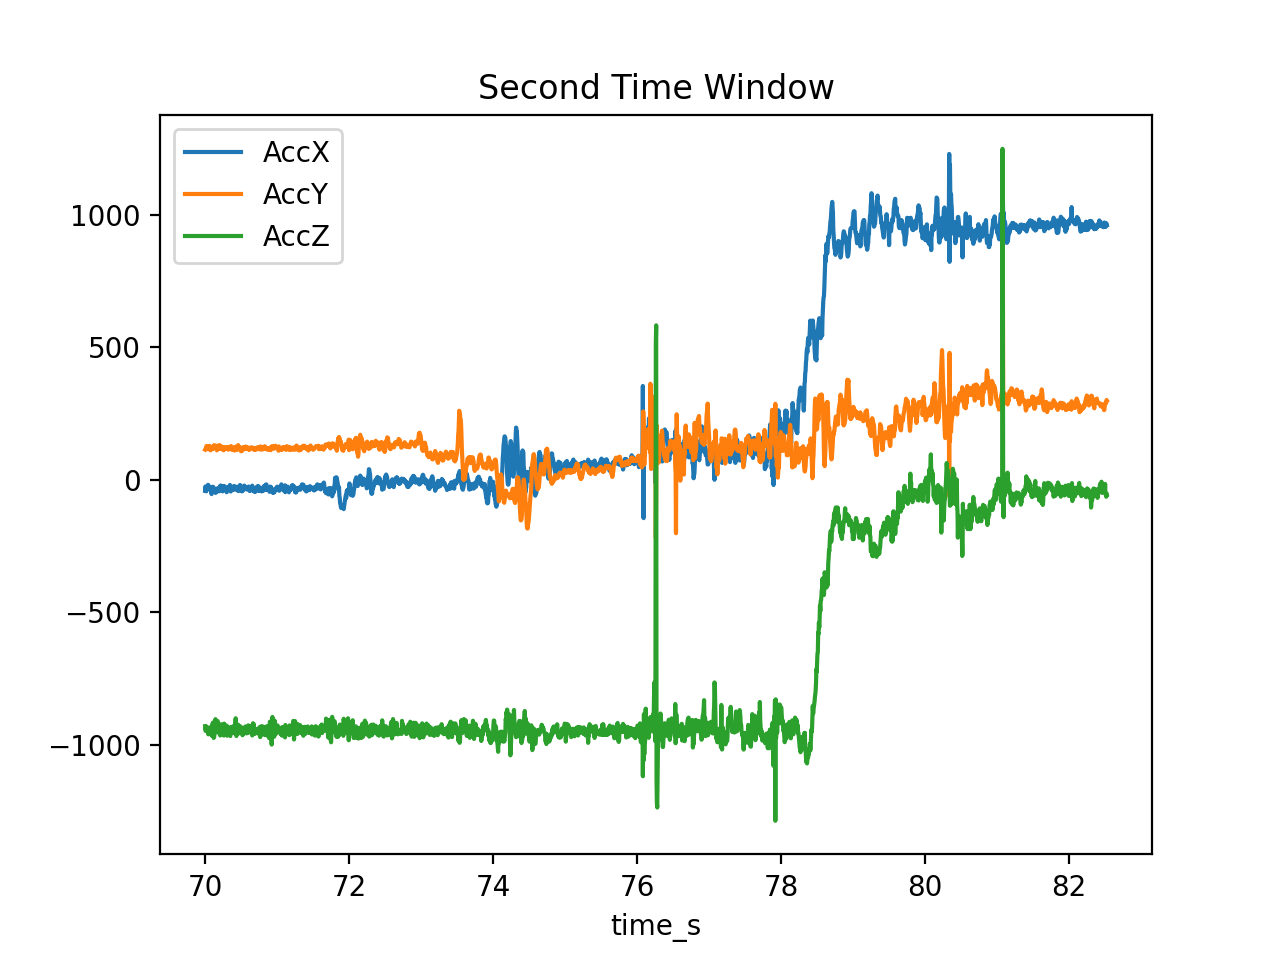

<AxesSubplot:title={'center':'Second Time Window'}, xlabel='time_s'>

In [4]:
# now let's look at the acceleration vector by plotting its three components

new_df.plot(y=['AccX','AccY','AccZ'], title= 'Accelerometer data (raw)')
new_df.loc[0:6].plot(y=['AccX','AccY','AccZ'],title='First Time Window')
new_df.loc[70:].plot(y=['AccX','AccY','AccZ'],title='Second Time Window')

In [5]:
#clean up the data (we select a time intervall from 10s to 70s)

data=new_df.loc[10:70].copy()

data

AccX     AccY     AccZ     GyroX     GyroY     GyroZ
time_s                                                        
10.000 -32.635  112.911 -953.796  1.755725  5.022901 -0.809160
10.005 -19.154  112.362 -971.608  1.557252  4.198473 -1.083969
10.010 -27.450  110.593 -944.280  0.931298  4.320611 -1.099237
10.015 -21.777  113.948 -940.803  0.946565  4.137404 -1.267176
10.020 -32.391  118.218 -924.394  1.022901  4.702290 -0.992366
...        ...      ...      ...       ...       ...       ...
69.980 -30.866  118.767 -941.108 -3.175573  3.358779 -0.778626
69.985 -32.818  118.279 -942.145 -2.992366  3.679389 -0.549618
69.990 -22.692  113.704 -948.184 -3.022901  3.786260 -0.564886
69.995 -38.674  119.743 -937.143 -2.854962  3.419847 -0.885496
70.000 -41.419  113.826 -928.847 -2.900763  2.946565 -0.839695

[12001 rows x 6 columns]

<IPython.core.display.Javascript object>


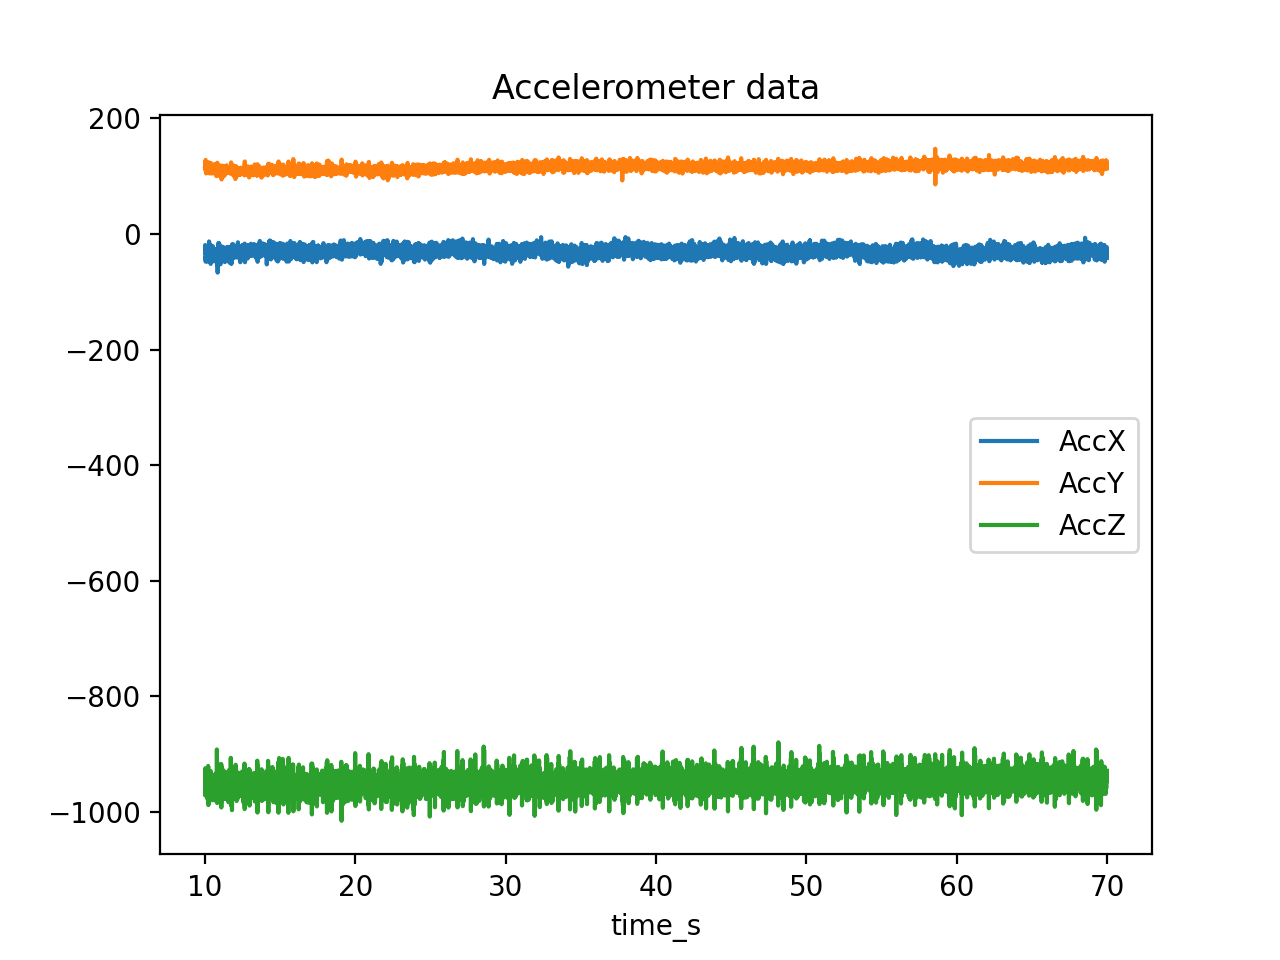

<AxesSubplot:title={'center':'Accelerometer data'}, xlabel='time_s'>

In [6]:
data.plot(y=['AccX','AccY','AccZ'],title= 'Accelerometer data')

<IPython.core.display.Javascript object>


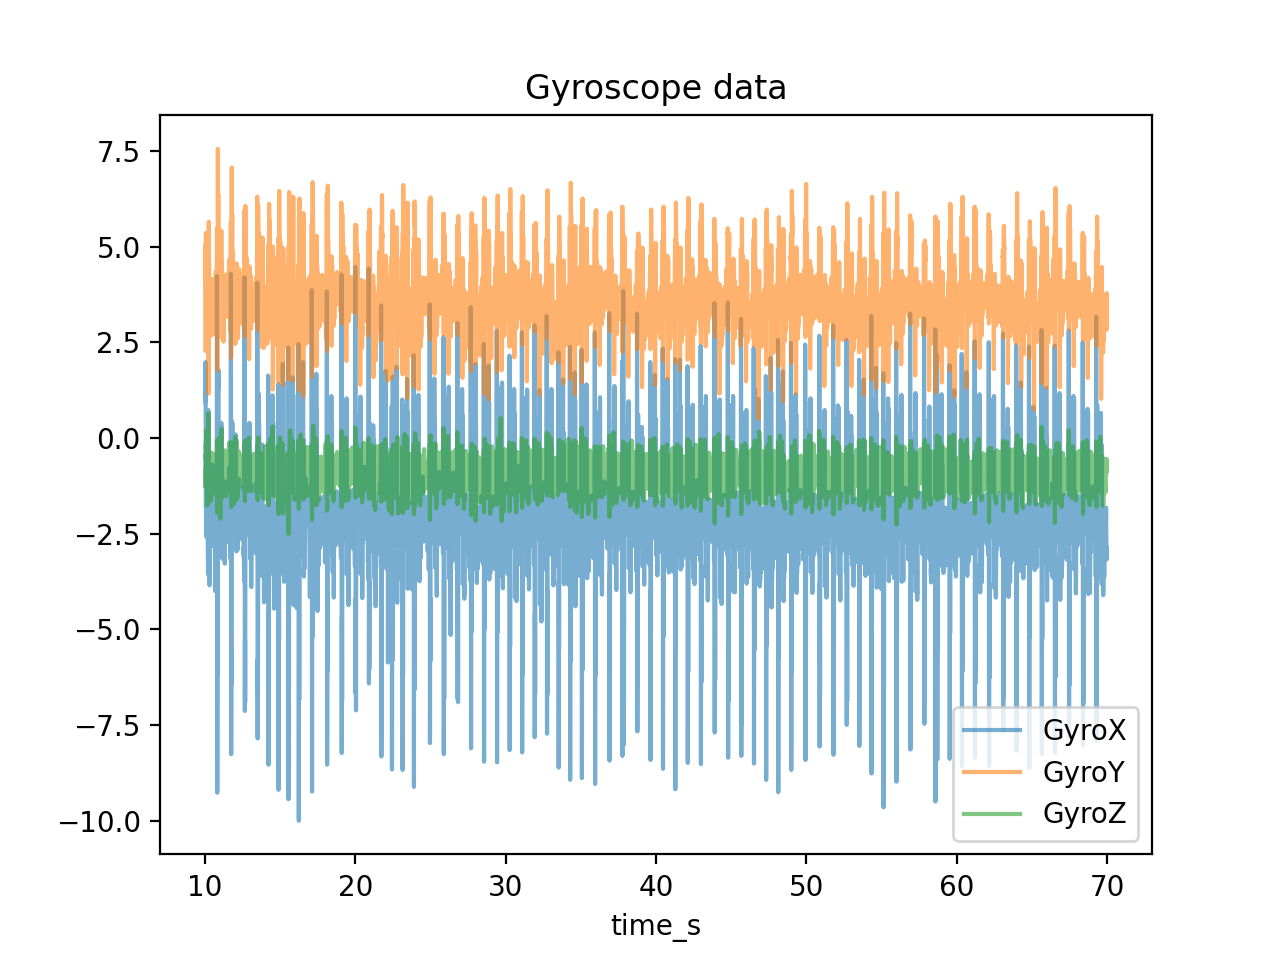

<AxesSubplot:title={'center':'Gyroscope data'}, xlabel='time_s'>

In [7]:
data.plot(y=['GyroX','GyroY','GyroZ'],title= 'Gyroscope data',alpha=0.6)

In [8]:
#normalize dataset

data=(data-data.mean())/data.std()
data

AccX      AccY      AccZ     GyroX     GyroY     GyroZ
time_s                                                            
10.000 -0.280383 -0.499810 -0.326615  2.717898  1.880348  0.164004
10.005  1.643869 -0.602838 -1.563713  2.577433  0.723583 -0.593129
10.010  0.459714 -0.934819  0.334301  2.134425  0.894956 -0.635194
10.015  1.269467 -0.305200  0.575790  2.145230  0.637896 -1.097887
10.020 -0.245555  0.496132  1.715446  2.199256  1.430495 -0.340752
...          ...       ...       ...       ...       ...       ...
69.980 -0.027879  0.599161  0.554607 -0.772136 -0.454602  0.248130
69.985 -0.306504  0.507580  0.482584 -0.642474 -0.004750  0.879075
69.990  1.138862 -0.350991  0.063156 -0.664085  0.145202  0.837012
69.995 -1.142378  0.782322  0.829988 -0.545229 -0.368917 -0.046311
70.000 -1.534194 -0.328095  1.406171 -0.577644 -1.032985  0.079878

[12001 rows x 6 columns]

<IPython.core.display.Javascript object>


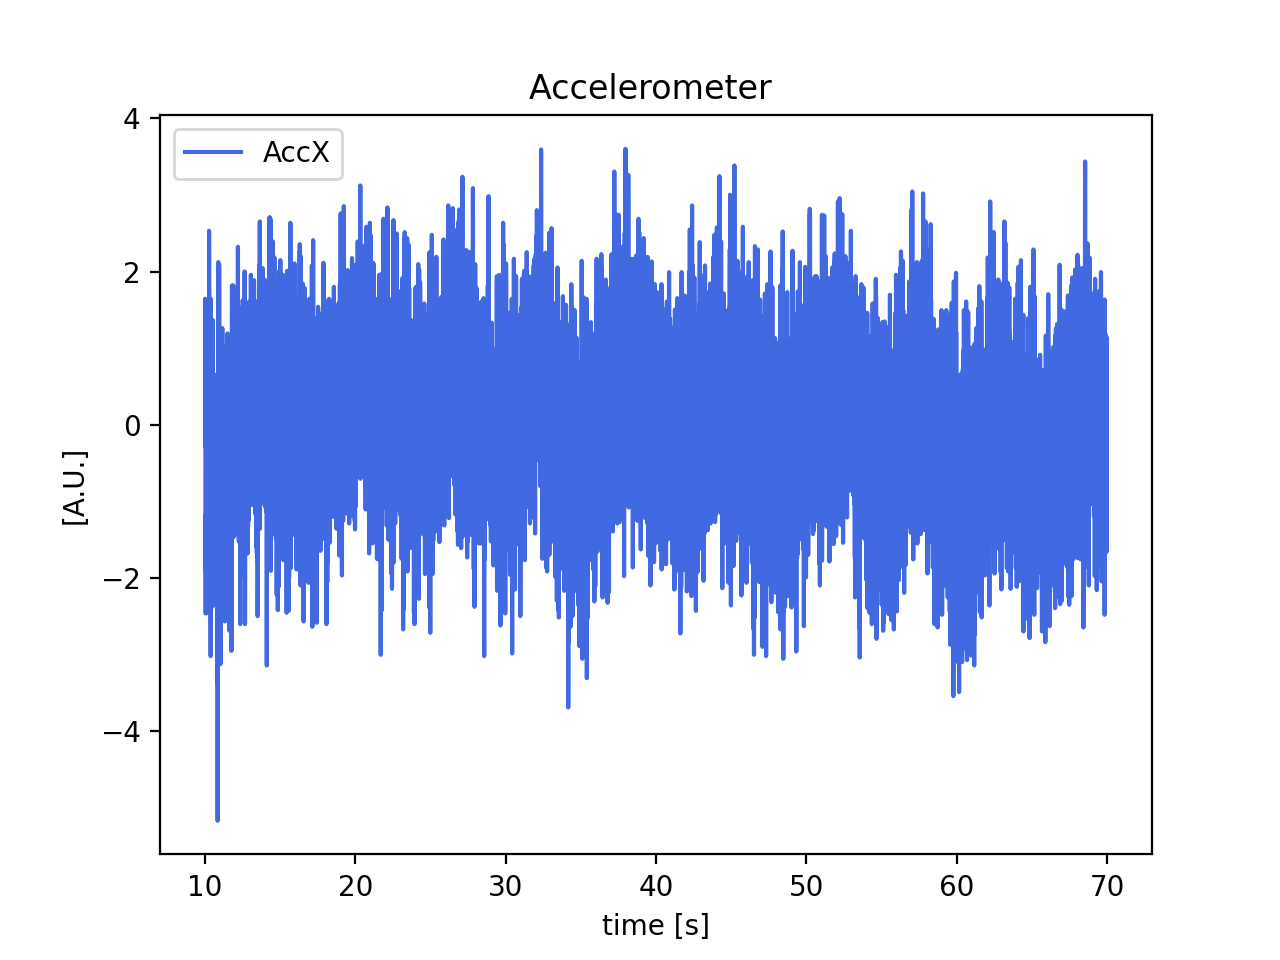

<IPython.core.display.Javascript object>


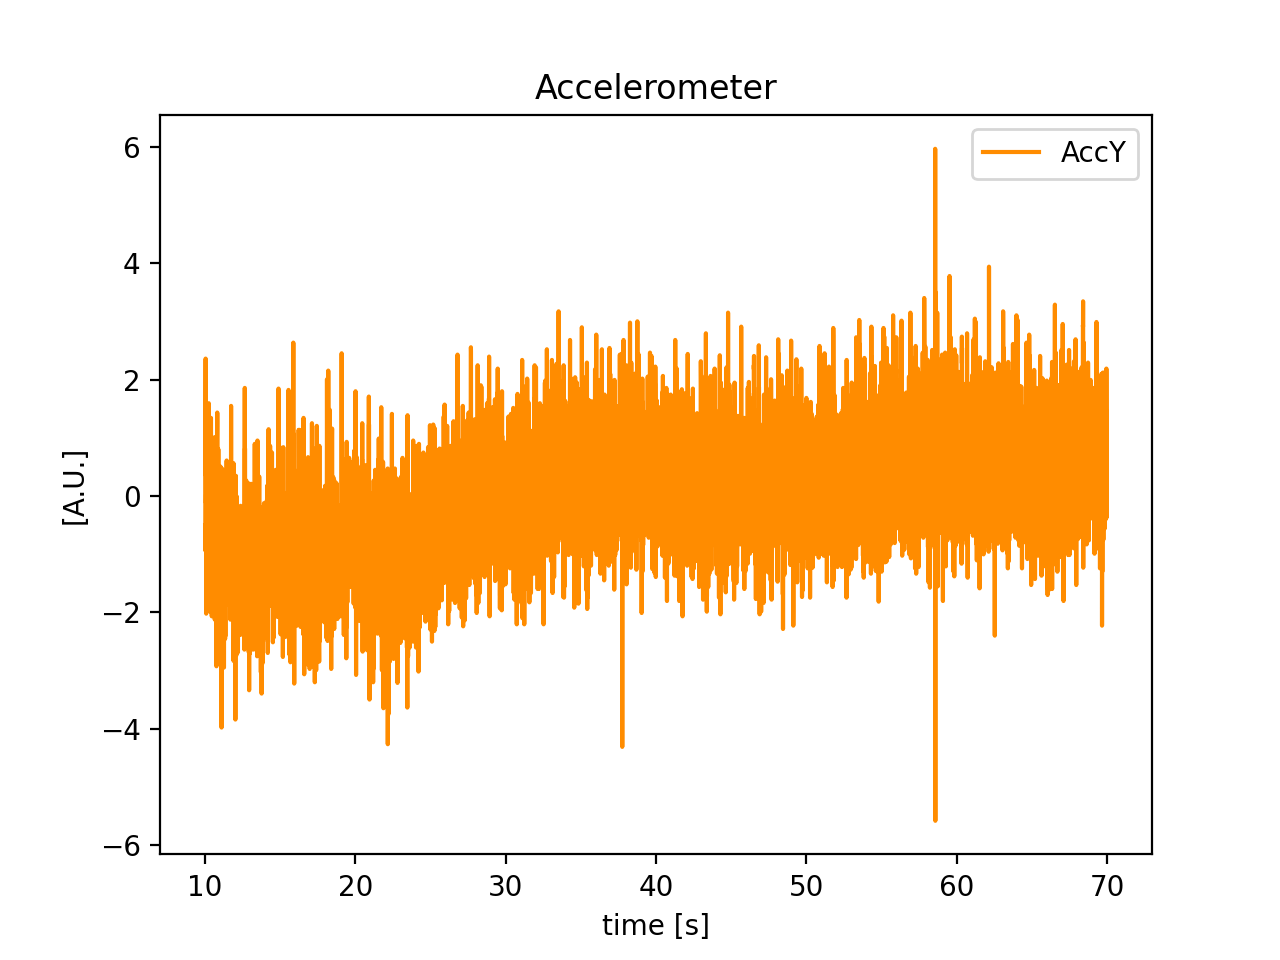

<IPython.core.display.Javascript object>


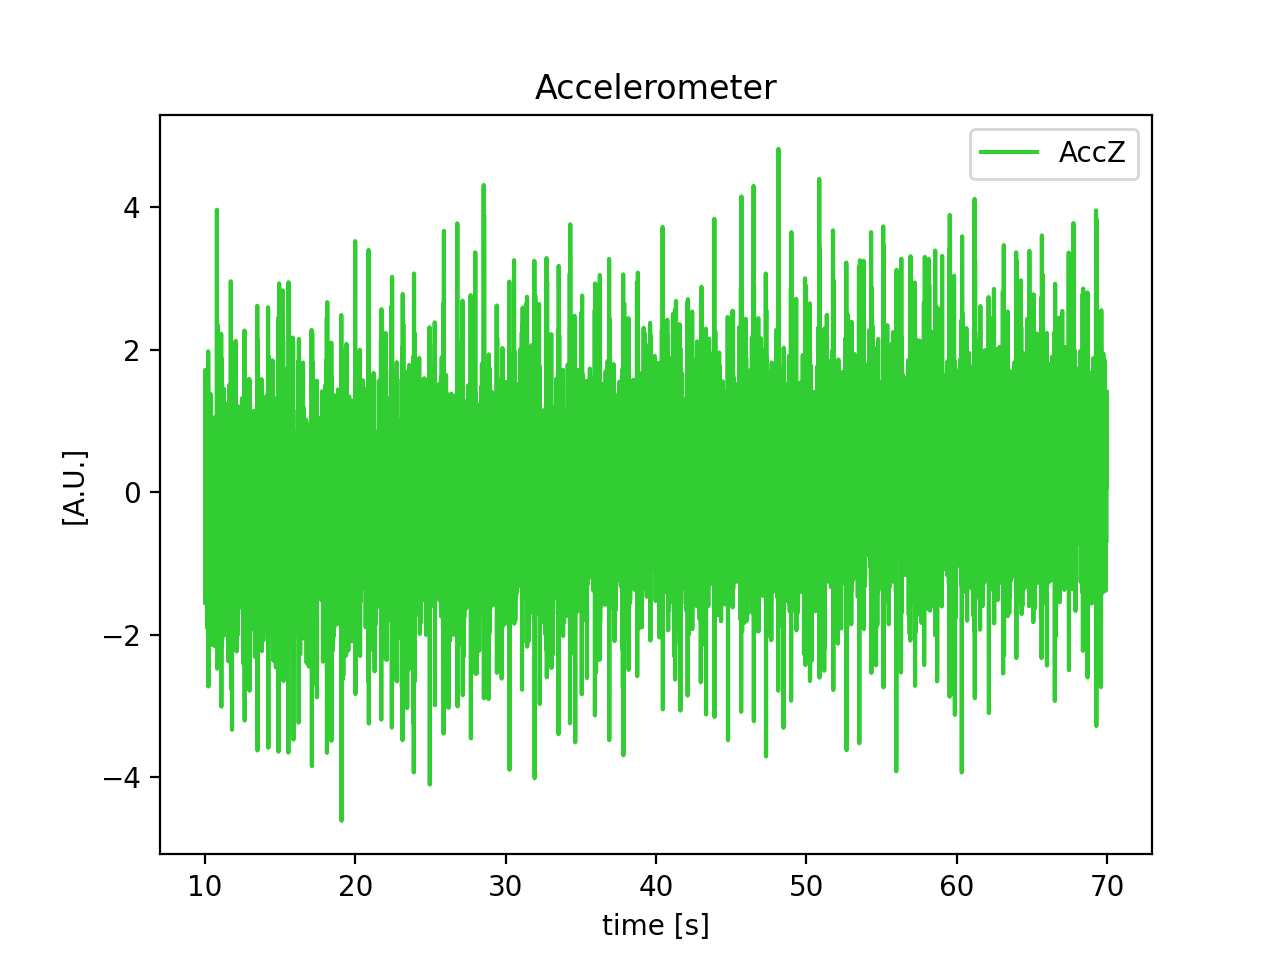

<AxesSubplot:title={'center':'Accelerometer'}, xlabel='time [s]', ylabel='[A.U.]'>

In [9]:
#accelerometer plots

data.plot(y=['AccX'],color='royalblue', title='Accelerometer ',ylabel='[A.U.]', xlabel='time [s]')
data.plot(y=['AccY'],color='darkorange', title='Accelerometer',ylabel='[A.U.]', xlabel='time [s]')
data.plot(y=['AccZ'],color='limegreen', title='Accelerometer',ylabel='[A.U.]', xlabel='time [s]')

<IPython.core.display.Javascript object>


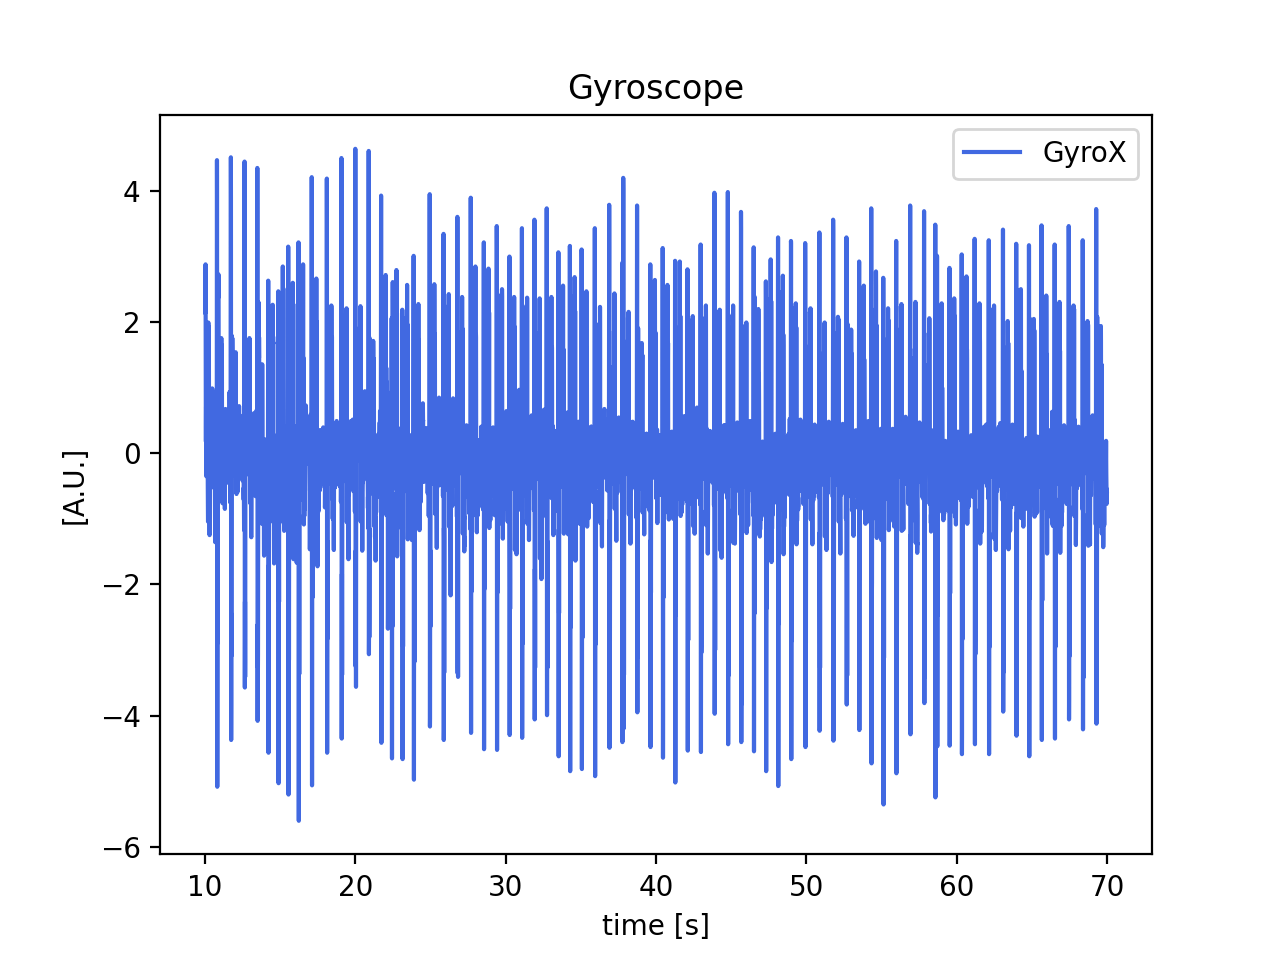

<IPython.core.display.Javascript object>


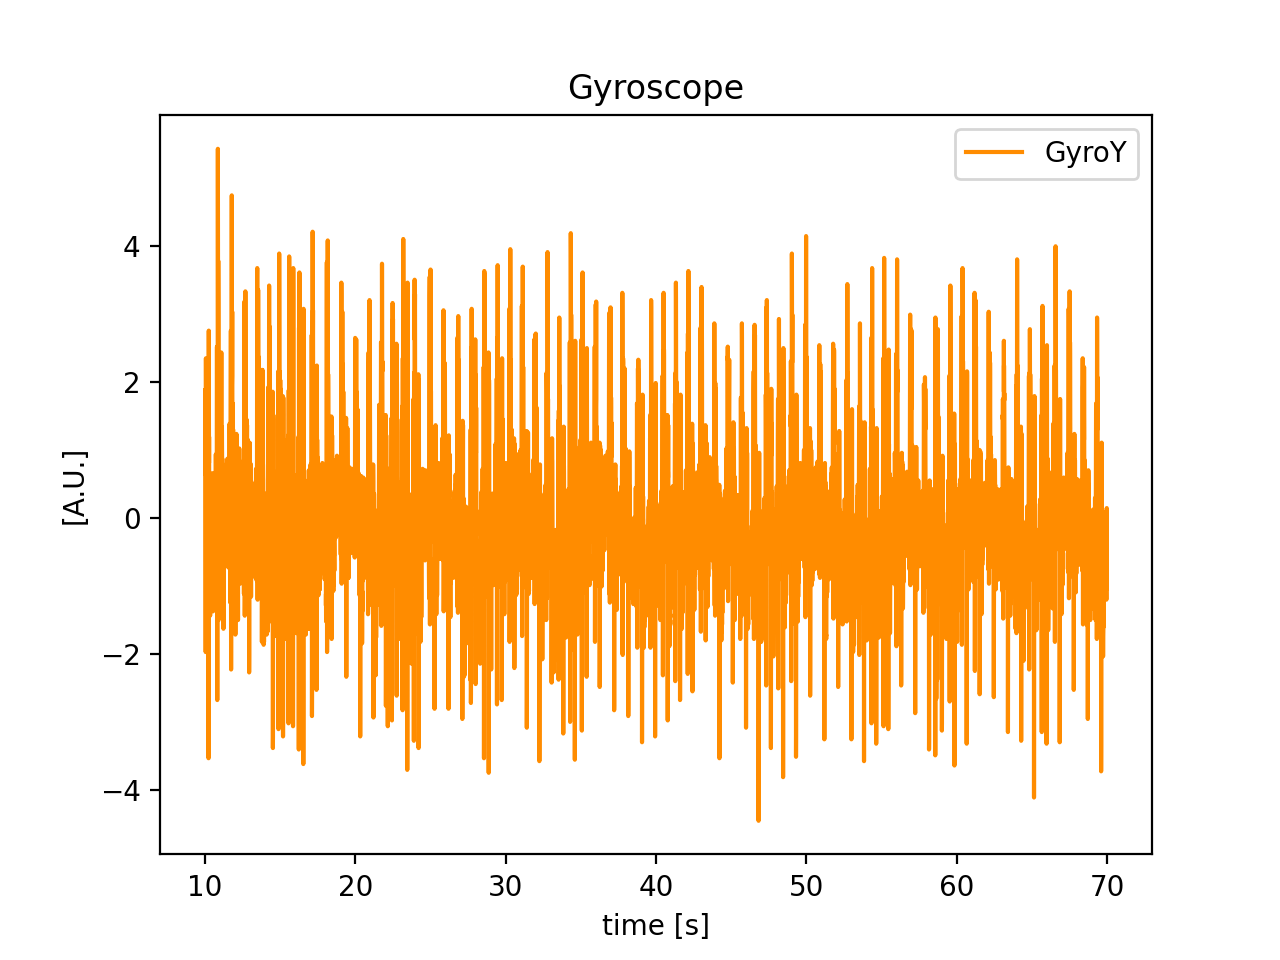

<IPython.core.display.Javascript object>


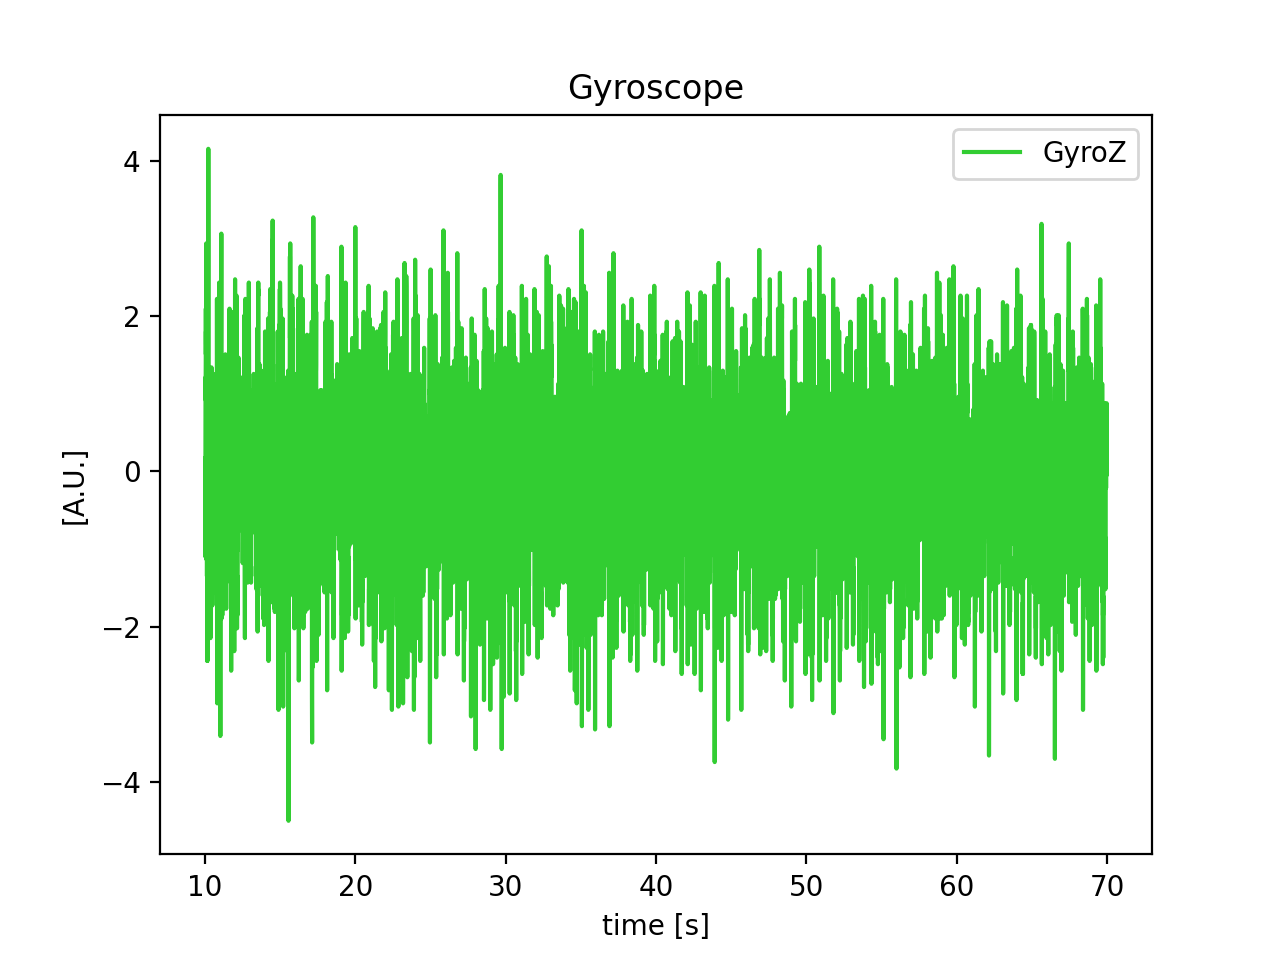

<AxesSubplot:title={'center':'Gyroscope'}, xlabel='time [s]', ylabel='[A.U.]'>

In [10]:
#gyroscope plots

data.plot(y=['GyroX'],color='royalblue', title='Gyroscope',ylabel='[A.U.]', xlabel='time [s]')
data.plot(y=['GyroY'],color='darkorange', title='Gyroscope',ylabel='[A.U.]', xlabel='time [s]')
data.plot(y=['GyroZ'],color='limegreen', title='Gyroscope',ylabel='[A.U.]', xlabel='time [s]')

         AccX     AccY     AccZ
AccX  1.00000 -0.17752 -0.41053
AccY -0.17752  1.00000  0.16844
AccZ -0.41053  0.16844  1.00000 

Contributions to variance along the three eigenvectors' direction:
[0.508 0.196 0.295]


<IPython.core.display.Javascript object>


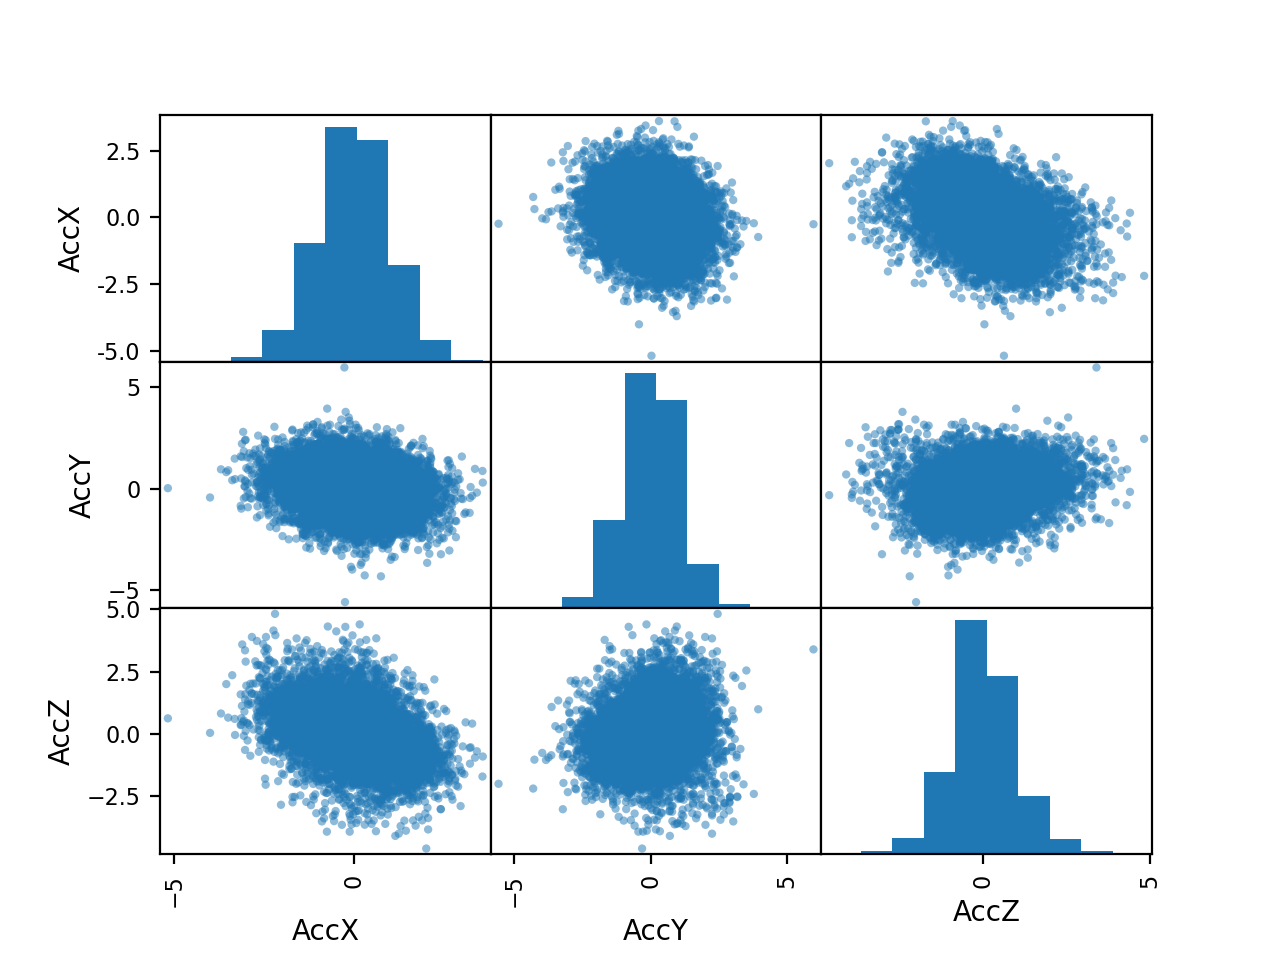

<IPython.core.display.Javascript object>


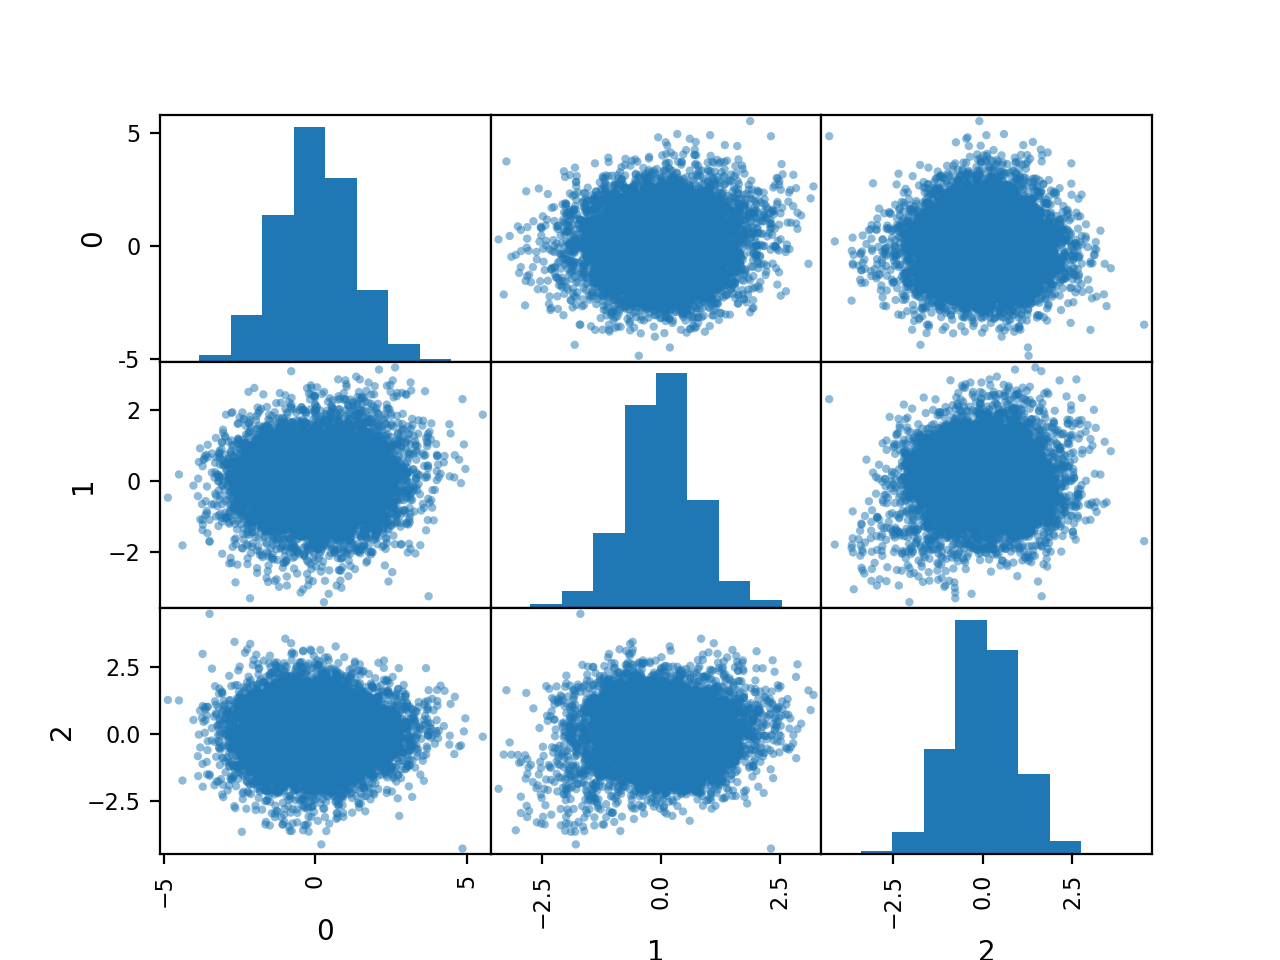

array([[<AxesSubplot:xlabel='0', ylabel='0'>,
        <AxesSubplot:xlabel='1', ylabel='0'>,
        <AxesSubplot:xlabel='2', ylabel='0'>],
       [<AxesSubplot:xlabel='0', ylabel='1'>,
        <AxesSubplot:xlabel='1', ylabel='1'>,
        <AxesSubplot:xlabel='2', ylabel='1'>],
       [<AxesSubplot:xlabel='0', ylabel='2'>,
        <AxesSubplot:xlabel='1', ylabel='2'>,
        <AxesSubplot:xlabel='2', ylabel='2'>]], dtype=object)

In [11]:
#PCA acc

c_acc=data[['AccX','AccY','AccZ']].cov()
print(c_acc,'\n')
l_acc,V_acc=la.eig(c_acc) #V[:,i] is the normalized eigenvector corresponding to the l[i] eigenvalue 
l_r_acc=np.real_if_close(l_acc)
print("Contributions to variance along the three eigenvectors' direction:")
with np.printoptions(precision=3, suppress=True):
    print(l_r_acc/c_acc.values.trace()) 
data_acc_transf = (V_acc.T @ data[['AccX','AccY','AccZ']].T).T

pd.plotting.scatter_matrix(data[['AccX','AccY','AccZ']])
pd.plotting.scatter_matrix(data_acc_transf)

          GyroX     GyroY     GyroZ
GyroX  1.000000  0.395858  0.383151
GyroY  0.395858  1.000000  0.436093
GyroZ  0.383151  0.436093  1.000000 

Contributions to variance along the three eigenvectors' direction:
[0.603 0.209 0.188]


<IPython.core.display.Javascript object>


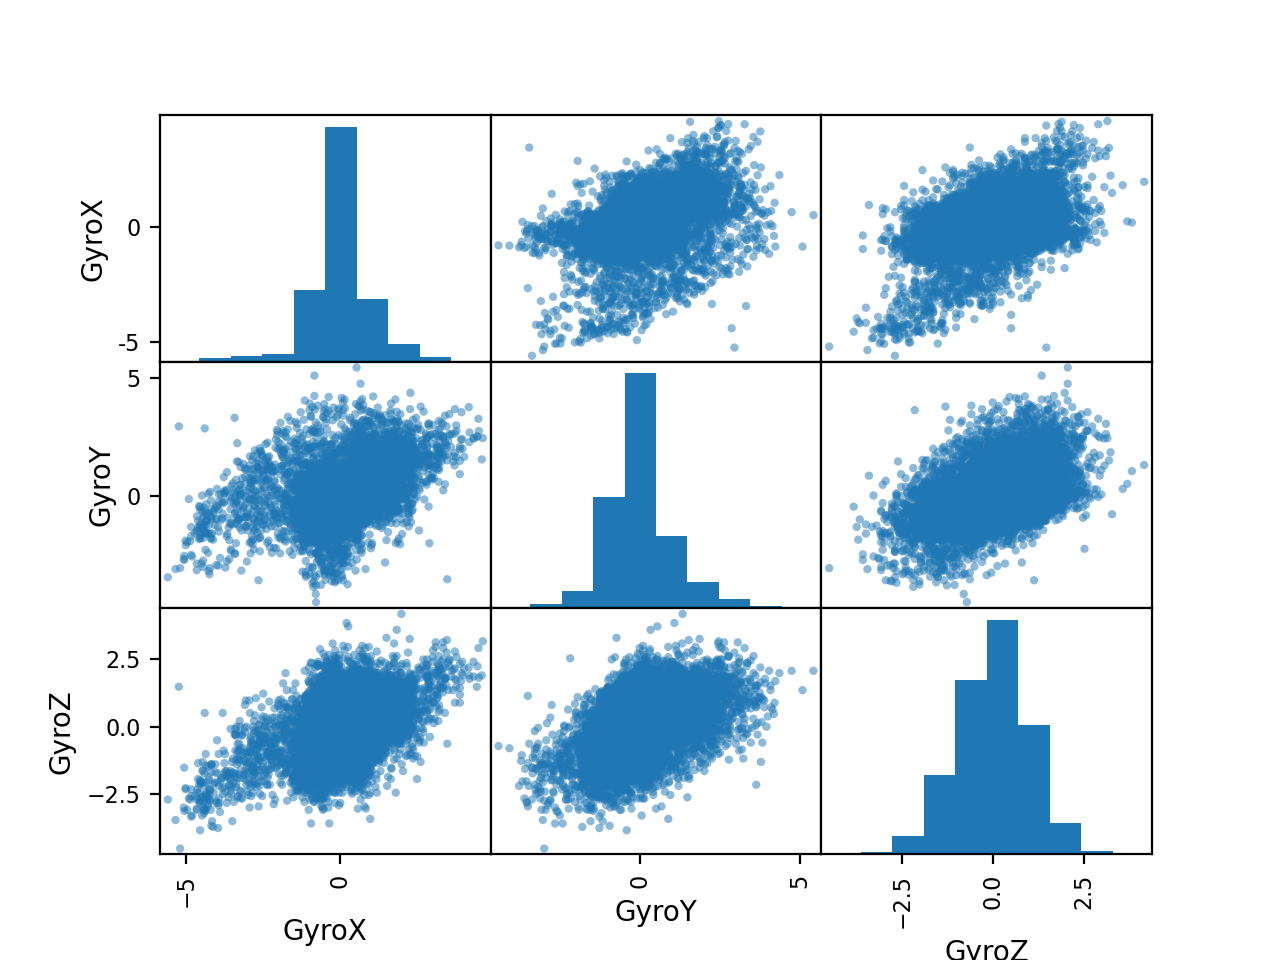

<IPython.core.display.Javascript object>


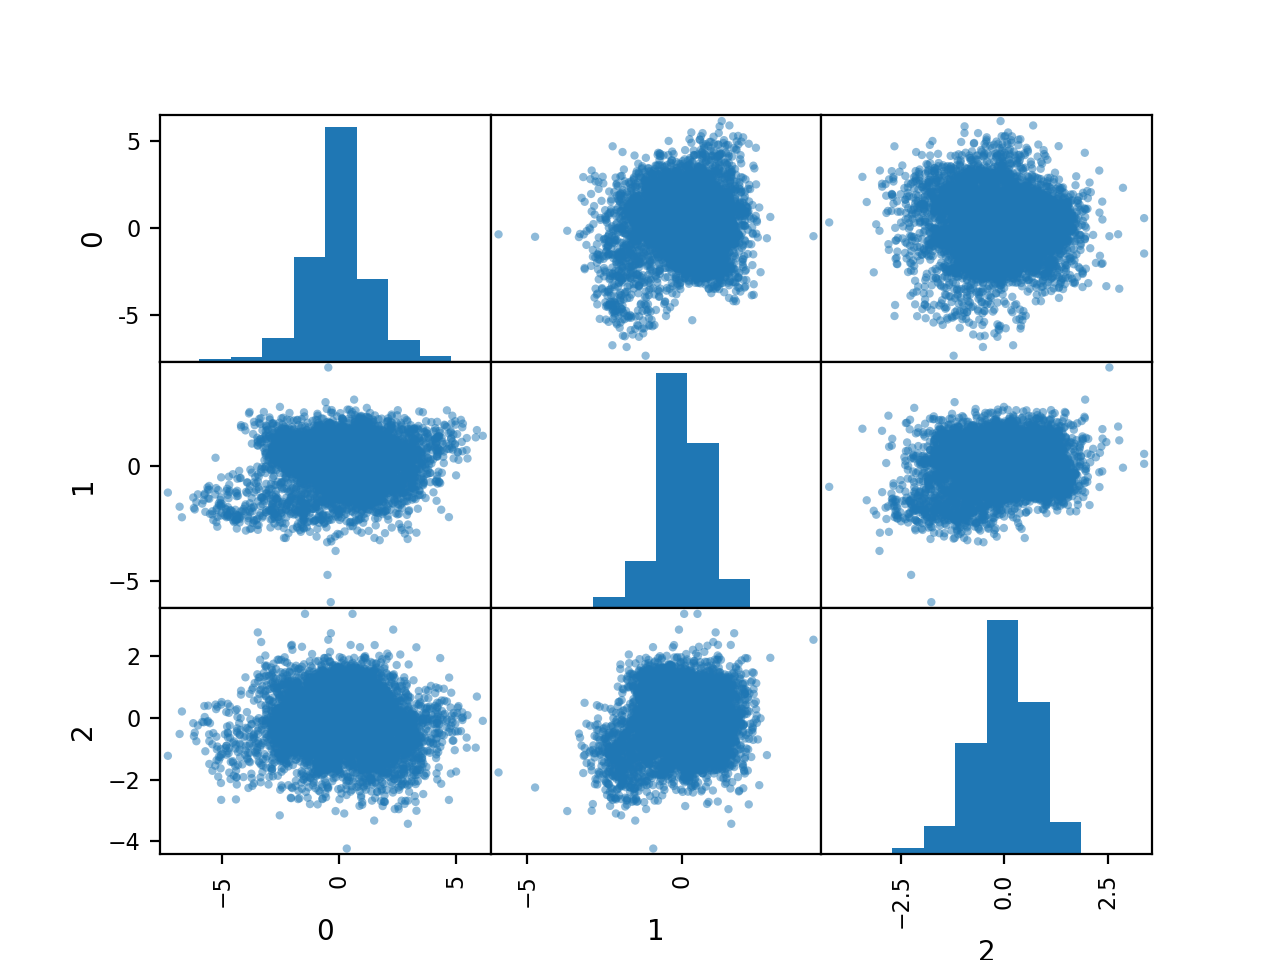

array([[<AxesSubplot:xlabel='0', ylabel='0'>,
        <AxesSubplot:xlabel='1', ylabel='0'>,
        <AxesSubplot:xlabel='2', ylabel='0'>],
       [<AxesSubplot:xlabel='0', ylabel='1'>,
        <AxesSubplot:xlabel='1', ylabel='1'>,
        <AxesSubplot:xlabel='2', ylabel='1'>],
       [<AxesSubplot:xlabel='0', ylabel='2'>,
        <AxesSubplot:xlabel='1', ylabel='2'>,
        <AxesSubplot:xlabel='2', ylabel='2'>]], dtype=object)

In [12]:
#PCA gyro

c_gyro=data[['GyroX','GyroY','GyroZ']].cov()
print(c_gyro,'\n')
l_gyro,V_gyro=la.eig(c_gyro) #V[:,i] is the normalized eigenvector corresponding to the l[i] eigenvalue 
l_r_gyro=np.real_if_close(l_gyro)
print("Contributions to variance along the three eigenvectors' direction:")
with np.printoptions(precision=3, suppress=True):
    print(l_r_gyro/c_gyro.values.trace()) 
data_gyro_transf = (V_gyro.T @ data[['GyroX','GyroY','GyroZ']].T).T

pd.plotting.scatter_matrix(data[['GyroX','GyroY','GyroZ']])
pd.plotting.scatter_matrix(data_gyro_transf)

<IPython.core.display.Javascript object>


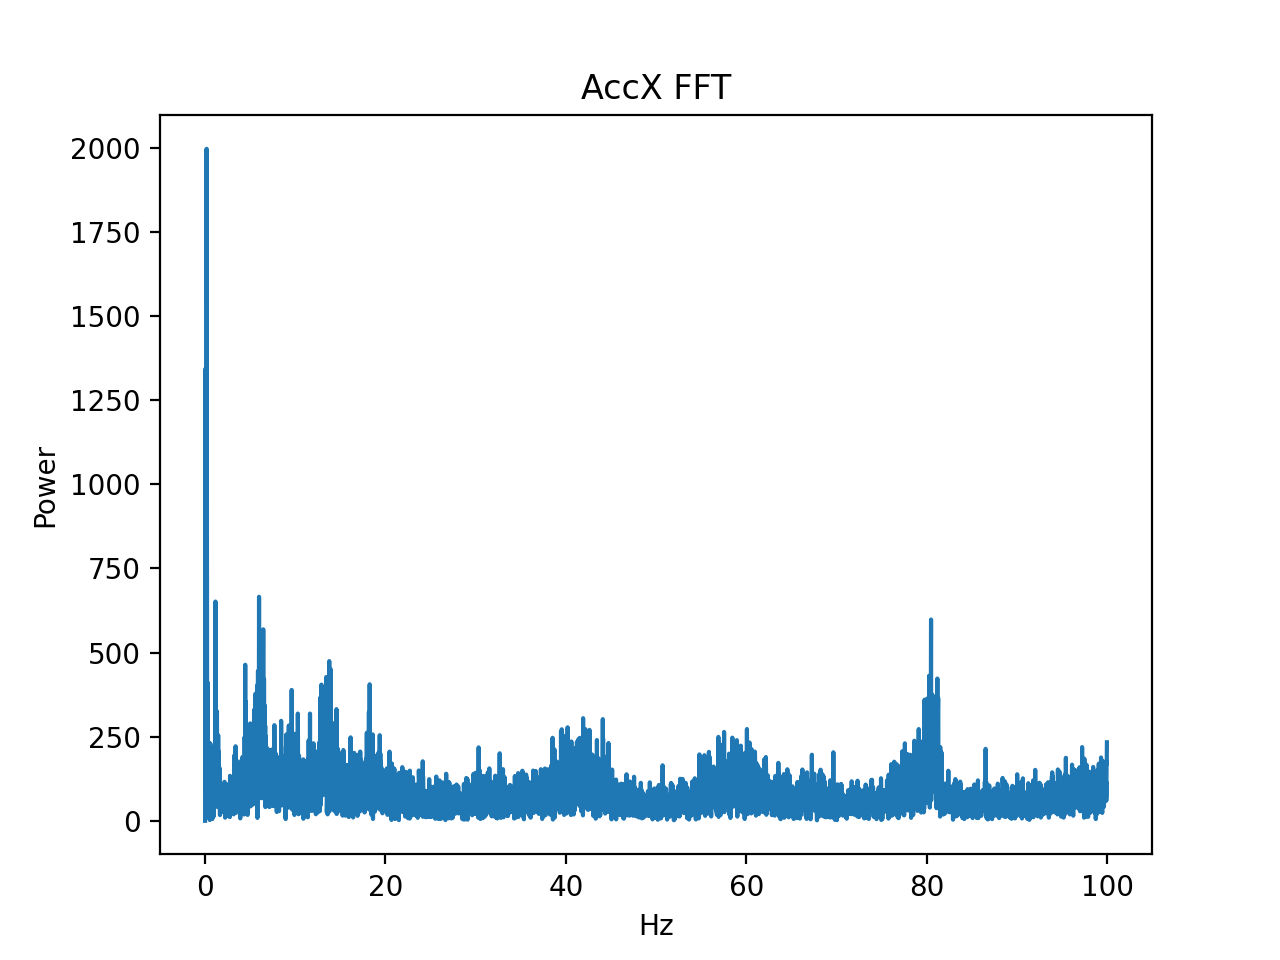

Text(0, 0.5, 'Power')

In [13]:
#fft

time_step=0.005

accX=data['AccX'].values

fft_accX=fft.fft(accX)
accX_freq = fft.fftfreq(accX.size, d=time_step)
power_accX = np.abs(fft_accX)

mask=np.where(accX_freq>=0)

accX_freq1=accX_freq[mask]
power_accX1=power_accX[mask]

fig, ax = plt.subplots()
ax.plot(accX_freq1,power_accX1)
ax.set_title('AccX FFT')
ax.set_xlabel('Hz')
ax.set_ylabel('Power')


<IPython.core.display.Javascript object>


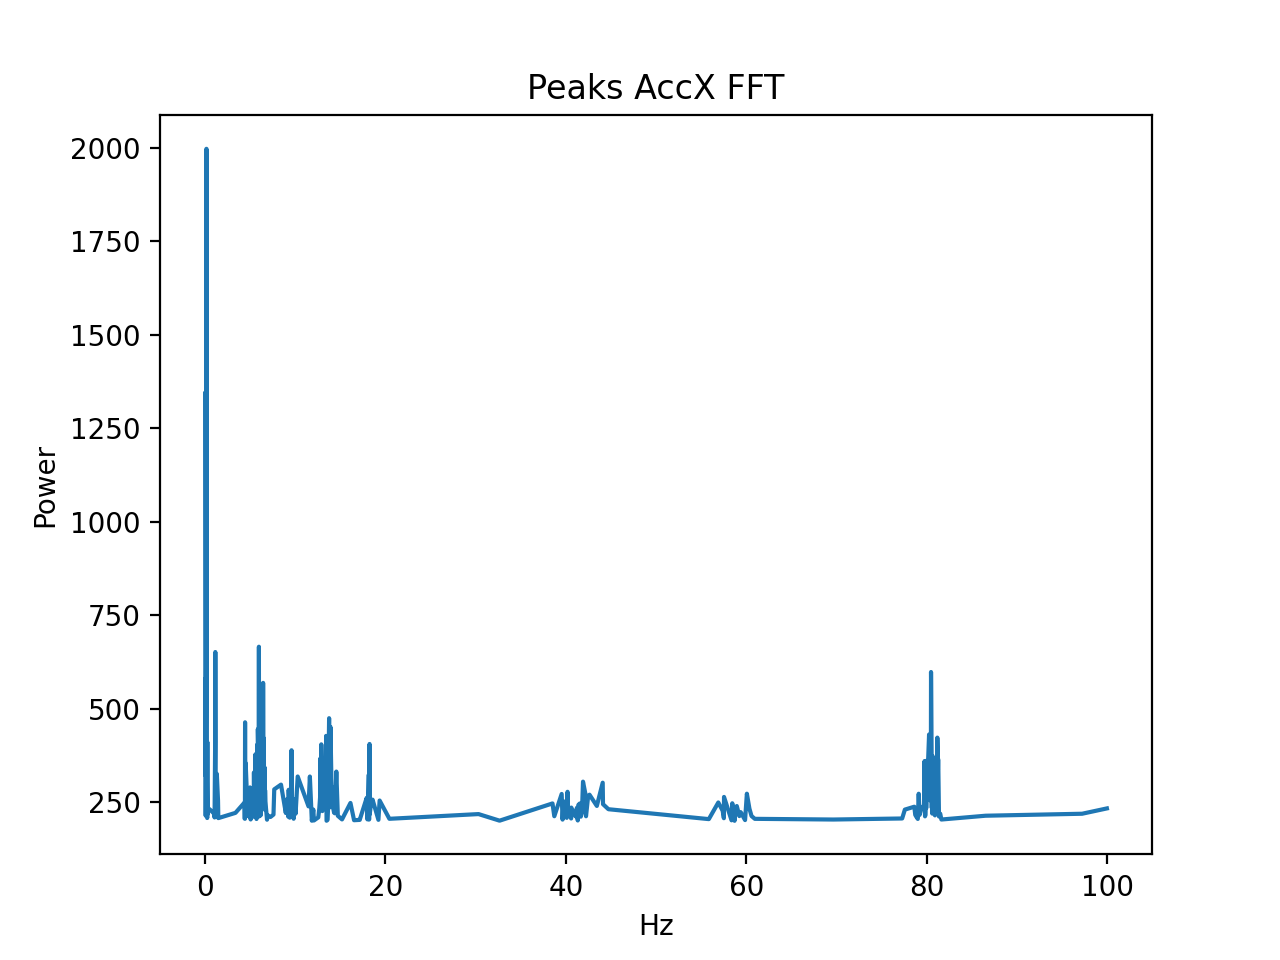

In [14]:
#filter

f=200

peaks_accX = accX_freq1[power_accX1>=f]
peaks_power=power_accX1[power_accX1>=f]
periods=np.array(1/i for i in peaks_accX)

fig, ax = plt.subplots()
ax.plot(peaks_accX,peaks_power)
ax.set_title('Peaks AccX FFT')
ax.set_xlabel('Hz')
ax.set_ylabel('Power')

solutions=np.vstack((peaks_accX, peaks_power)).T 
#print(solutions[0:10])